In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/home/pmchome/pmc-turbo/')

In [3]:
import glob
files = glob.glob('/home/pmcroot/data1/2016-08-18_50mm_star_focus_test/*.npz')
files.sort()

In [392]:
len(files)

6006

In [398]:
files[3206]

'/home/pmcroot/data1/2016-08-18_50mm_star_focus_test/2016-08-18_234556_focus_step_0000.npz'

In [90]:
imset = [np.load(files[4000+k])['image'].astype('float32') for k in range(20)]

In [9]:
import scipy.ndimage

In [72]:
im = imset[0]

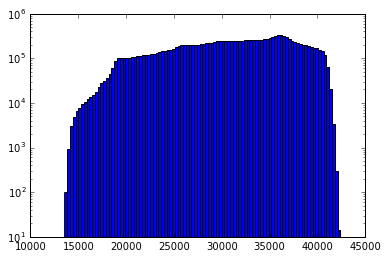

In [86]:
_=hist(im.flatten(),bins=100,log=True)

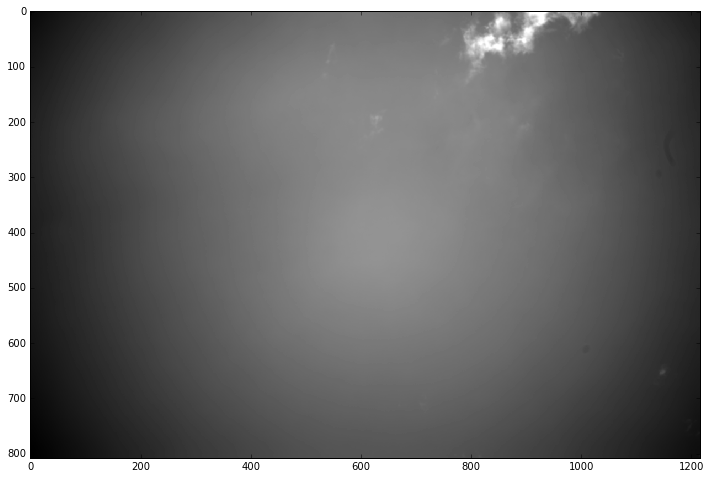

In [43]:
figure(figsize=(12,8))
imshow(scipy.ndimage.gaussian_filter(im,3)[::4,::4],aspect='auto',cmap=cm.gray,interpolation='nearest')

In [32]:
im.max()

65360.0

In [33]:
im.min()

13568.0

In [30]:
def brenner_contrast(im):
    im = im.astype('float32')
    dv = im[2:,2:]-im[:-2,2:]
    dh = im[2:,2:]-im[2:,:-2]
    return np.mean(np.max((dv,dh),axis=0)**2)
#def nanda_contrast(im):
    

In [37]:
im = im.astype('float32')
dv = im[2:,2:]-im[:-2,2:]
dh = im[2:,2:]-im[2:,:-2]

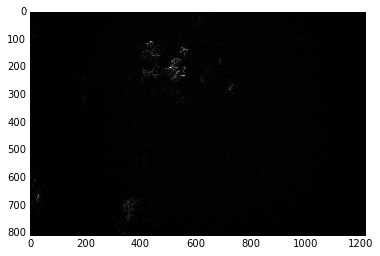

In [38]:
imshow(scipy.ndimage.gaussian_filter(np.max((dv,dh),axis=0)**2,3)[::4,::4],aspect='auto',cmap=cm.gray,interpolation='nearest')

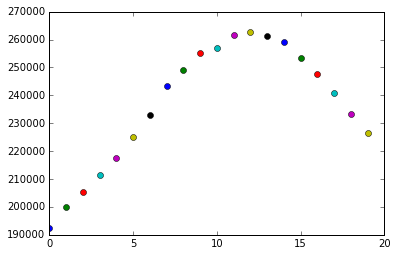

In [97]:
for k,im in enumerate(imset):
    plot(k,brenner_contrast(im[:1024,-2048:]),'o')

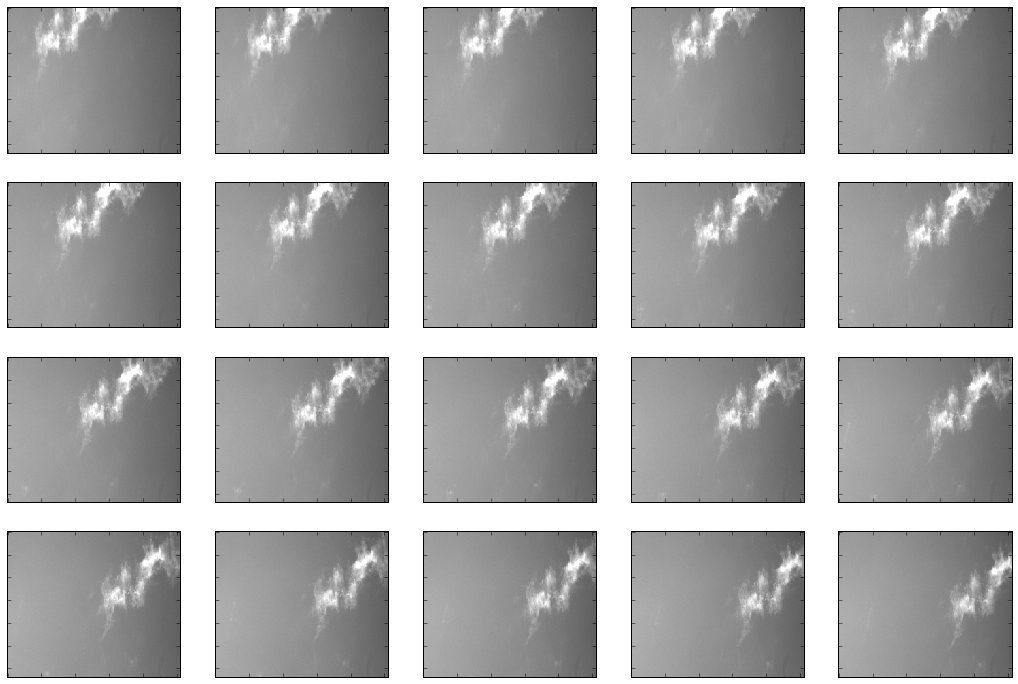

In [99]:
fig,axs = subplots(4,5,figsize=(18,12))
for k,ax in enumerate(axs.flatten()):
    imax = ax.imshow(imset[k][:1024,-2048:][::8,::8],aspect='auto',cmap=cm.gray,interpolation='nearest')
    imax.set_clim(0,2**16)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    

In [100]:
import scipy.signal

In [132]:
c = scipy.signal.fftconvolve((imset[0][:1024,-2048:]-imset[0][:1024,-2048:].mean())[::-1,::-1],imset[2][:1024,-2048:]-imset[2][:1024,-2048:].mean())

In [113]:
c.shape

(2047, 4095)

In [116]:
c.shape[0]//2

1023

In [117]:
c.shape[1]//2

2047

In [136]:
np.array(np.unravel_index(np.abs(c).argmax(),c.shape)) - (np.array(c.shape)//2)

array([ 22, 101])

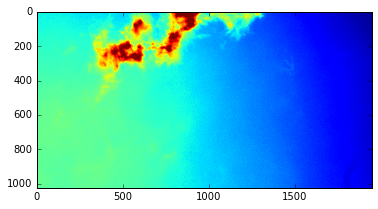

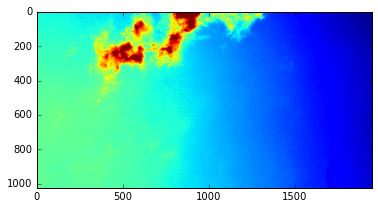

In [146]:
imshow(imset[0][:1024,-2048:-101])
figure()
imshow(imset[2][22:1024+22,-2048+101:])

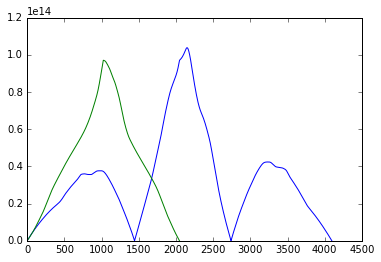

In [134]:
plot(np.abs(c[1023,:]))
plot(np.abs(c[:,2047]))


In [147]:
import cv2

In [ ]:
cv2.matchTemplate()

In [206]:
from __future__ import division, print_function

import math

import numpy
from numpy.fft import fft2, ifft2, fftshift

try:
    import scipy.ndimage.interpolation as ndii
except ImportError:
    import ndimage.interpolation as ndii

__version__ = '2013.01.18'
__docformat__ = 'restructuredtext en'
__all__ = ['translation', 'similarity']


def translation(im0, im1):
    """Return translation vector to register images."""
    shape = im0.shape
    im0 = im0-im0.mean()
    im1 = im1-im1.mean()
    f0 = fft2(im0)
    f1 = fft2(im1)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    ir[0,0] = 0
    t0, t1 = numpy.unravel_index(numpy.argmax(ir), shape)
    
    if t0 > shape[0] // 2:
        t0 -= shape[0]
    if t1 > shape[1] // 2:
        t1 -= shape[1]
    return [t0, t1],ir


def similarity(im0, im1):
    """Return similarity transformed image im1 and transformation parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector.

    A similarity transformation is an affine transformation with isotropic
    scale and without shear.

    Limitations:
    Image shapes must be equal and square.
    All image areas must have same scale, rotation, and shift.
    Scale change must be less than 1.8.
    No subpixel precision.

    """
    if im0.shape != im1.shape:
        raise ValueError("Images must have same shapes.")
    elif len(im0.shape) != 2:
        raise ValueError("Images must be 2 dimensional.")

    f0 = fftshift(abs(fft2(im0)))
    f1 = fftshift(abs(fft2(im1)))

    h = highpass(f0.shape)
    f0 *= h
    f1 *= h
    del h

    f0, log_base = logpolar(f0)
    f1, log_base = logpolar(f1)

    f0 = fft2(f0)
    f1 = fft2(f1)
    r0 = abs(f0) * abs(f1)
    ir = abs(ifft2((f0 * f1.conjugate()) / r0))
    i0, i1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)
    angle = 180.0 * i0 / ir.shape[0]
    scale = log_base ** i1

    if scale > 1.8:
        ir = abs(ifft2((f1 * f0.conjugate()) / r0))
        i0, i1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)
        angle = -180.0 * i0 / ir.shape[0]
        scale = 1.0 / (log_base ** i1)
        if scale > 1.8:
            raise ValueError("Images are not compatible. Scale change > 1.8")

    if angle < -90.0:
        angle += 180.0
    elif angle > 90.0:
        angle -= 180.0

    im2 = ndii.zoom(im1, 1.0/scale)
    im2 = ndii.rotate(im2, angle)

    if im2.shape < im0.shape:
        t = numpy.zeros_like(im0)
        t[:im2.shape[0], :im2.shape[1]] = im2
        im2 = t
    elif im2.shape > im0.shape:
        im2 = im2[:im0.shape[0], :im0.shape[1]]

    f0 = fft2(im0)
    f1 = fft2(im2)
    h = highpass(f0.shape)
    f0 *= (h)
    f1 *= (h)
    del h
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    ir[0,0] =0
    t0, t1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)

    if t0 > f0.shape[0] // 2:
        t0 -= f0.shape[0]
    if t1 > f0.shape[1] // 2:
        t1 -= f0.shape[1]

    im2 = ndii.shift(im2, [t0, t1])

    # correct parameters for ndimage's internal processing
    if angle > 0.0:
        d = int((int(im1.shape[1] / scale) * math.sin(math.radians(angle))))
        t0, t1 = t1, d+t0
    elif angle < 0.0:
        d = int((int(im1.shape[0] / scale) * math.sin(math.radians(angle))))
        t0, t1 = d+t1, d+t0
    scale = (im1.shape[1] - 1) / (int(im1.shape[1] / scale) - 1)

    return im2, scale, angle, [-t0, -t1]


def similarity_matrix(scale, angle, vector):
    """Return homogeneous transformation matrix from similarity parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector (of size 2).

    The order of transformations is: scale, rotate, translate.

    """
    S = numpy.diag([scale, scale, 1.0])
    R = numpy.identity(3)
    angle = math.radians(angle)
    R[0, 0] = math.cos(angle)
    R[1, 1] = math.cos(angle)
    R[0, 1] = -math.sin(angle)
    R[1, 0] = math.sin(angle)
    T = numpy.identity(3)
    T[:2, 2] = vector
    return numpy.dot(T, numpy.dot(R, S))


def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = numpy.empty((angles, radii), dtype=numpy.float64)
    theta.T[:] = -numpy.linspace(0, numpy.pi, angles, endpoint=False)
    #d = radii
    d = numpy.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (math.log10(d) / (radii))
    radius = numpy.empty_like(theta)
    radius[:] = numpy.power(log_base, numpy.arange(radii,
                                                   dtype=numpy.float64)) - 1.0
    x = radius * numpy.sin(theta) + center[0]
    y = radius * numpy.cos(theta) + center[1]
    output = numpy.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base


def highpass(shape):
    """Return highpass filter to be multiplied with fourier transform."""
    x = numpy.outer(
        numpy.cos(numpy.linspace(-math.pi/2., math.pi/2., shape[0])),
        numpy.cos(numpy.linspace(-math.pi/2., math.pi/2., shape[1])))
    return (1.0 - x) * (2.0 - x)


def imread(fname, norm=True):
    """Return image data from img&hdr uint8 files."""
    with open(fname+'.hdr', 'r') as fh:
        hdr = fh.readlines()
    img = numpy.fromfile(fname+'.img', numpy.uint8, -1)
    img.shape = int(hdr[4].split()[-1]), int(hdr[3].split()[-1])
    if norm:
        img = img.astype(numpy.float64)
        img /= 255.0
    return img


def imshow(im0, im1, im2, im3=None, cmap=None, **kwargs):
    """Plot images using matplotlib."""
    from matplotlib import pyplot
    if cmap is None:
        cmap = 'coolwarm'
    if im3 is None:
        im3 = abs(im2 - im0)
    pyplot.subplot(221)
    pyplot.imshow(im0, cmap, **kwargs)
    pyplot.subplot(222)
    pyplot.imshow(im1, cmap, **kwargs)
    pyplot.subplot(223)
    pyplot.imshow(im3, cmap, **kwargs)
    pyplot.subplot(224)
    pyplot.imshow(im2, cmap, **kwargs)
    pyplot.show()

In [215]:
im2,scale,angle,(t0,t1) = similarity(imset[0][:1024,-2048:-1024],imset[2][:1024,-2048:-1024])

In [299]:
(t0,t1),ir = translation(imset[0][512:1024,-2048:-1024],imset[1][:1024,-2048:-1024])

ValueError: operands could not be broadcast together with shapes (512,1024) (1024,1024) 

In [326]:
x = cv2.matchTemplate(imset[10],imset[1][256:1024,-2048:-1024],cv2.TM_CCORR_NORMED)

1 loop, best of 3: 2.07 s per loop


In [330]:
imset[1][256:1024,-2048:-1024].shape

(768, 1024)

In [4]:
from pmc_camera.star_finding import cloud_focus
reload(cloud_focus)

/home/pmchome/pmc-turbo/pmc_camera/__init__.py:6: UserWarning: Could not import PyCamera
  _warnings.warn("Could not import PyCamera")


<module 'pmc_camera.star_finding.cloud_focus' from '/home/pmchome/pmc-turbo/pmc_camera/star_finding/cloud_focus.pyc'>

In [349]:
files[0]

'/home/pmcroot/data1/2016-08-08_morning_with_ND_filter/2016-08-08_093705_focus_step_0000.npz'

In [359]:
f2 = glob.glob('/home/pmcroot/data1/2016-08-24_50mm_star_focus_test_100ms/*.npz')
f2.sort()

In [360]:
len(f2)

31410

In [416]:
imd = np.load(files[3406])['image']

In [417]:
imd.flatten().argsort().shape

(15720448,)

In [423]:
np.unravel_index(imd.flatten().argsort()[-3],imd.shape)

(1612, 4428)

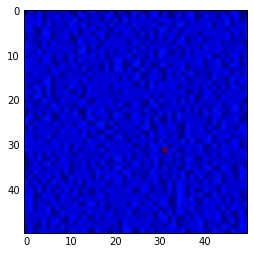

In [421]:
plt.imshow(imd[700:750,4425:4475])

In [6]:
stamps = cloud_focus.get_aligned_stamps(files[3206:3606:10],size=256,center=(1612, 4428),track=False)

In [12]:
ts = np.array([np.load(fn)['state'][()]['time'] for fn in files[3206:3606:10]])

In [7]:
len(stamps)

40

In [9]:
import scipy.ndimage

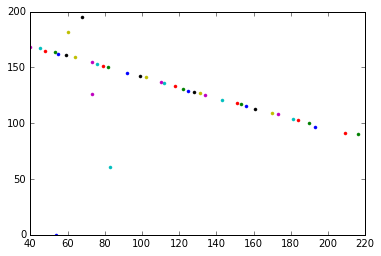

In [14]:
xy = []
for stamp in stamps:
    x,y = np.unravel_index(scipy.ndimage.gaussian_filter(stamp,3).flatten().argmax(),stamp.shape)
    xy.append((x,y))
    plot(x,y,'.')

In [15]:
xy = np.array(xy)

In [18]:
xy.shape

(40, 2)

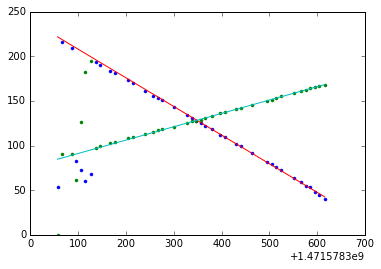

In [22]:
px = np.polyfit(ts[20:],xy[20:,0],1)
py = np.polyfit(ts[20:],xy[20:,1],1)

plot(ts,xy,'.')
plot(ts,np.polyval(px,ts))
plot(ts,np.polyval(py,ts))

In [38]:
stars = []
times = []
for fn in files[3206:3606]:
    npz = np.load(fn)
    imtime = npz['state'][()]['time']
    x = int(np.polyval(px,imtime))+1612-128
    y = int(np.polyval(py,imtime))+4428-128
    stars.append(npz['image'][x-32:x+32,y-32:y+32].copy())
    times.append(imtime)
    del npz

In [32]:
fn

'/home/pmcroot/data1/2016-08-18_50mm_star_focus_test/2016-08-18_235541_focus_step_0399.npz'

In [47]:
stamp.shape

(64, 64)

In [48]:
stamp[32,30:34].shape

(4,)

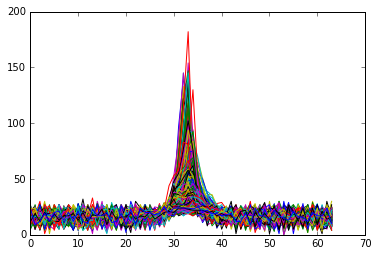

In [49]:
for stamp in stars:
    plot(stamp[30:34,:].mean(0)//16)

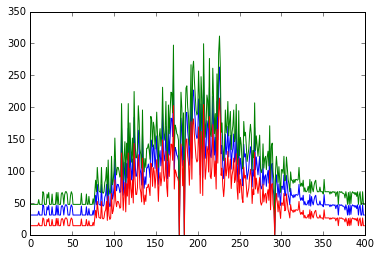

In [71]:
plot([stamp.max()/16. for stamp in stars])
plot([(stamp.max()/16+3*np.sqrt(stamp.max()/16)) for stamp in stars])
plot([(stamp.max()/16-3*np.sqrt(stamp.max()/16)) for stamp in stars])      

In [20]:
px

array([ -3.20893092e-01,   4.72219551e+08])

In [93]:
ss = 0
for star in stars[205:215]:#[150:250]:
    ss += star.astype('float')

In [87]:
star = stars[210]

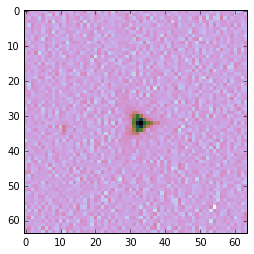

In [94]:
imshow(np.sqrt(ss-ss.min()),cmap=cm.cubehelix_r,interpolation='nearest')

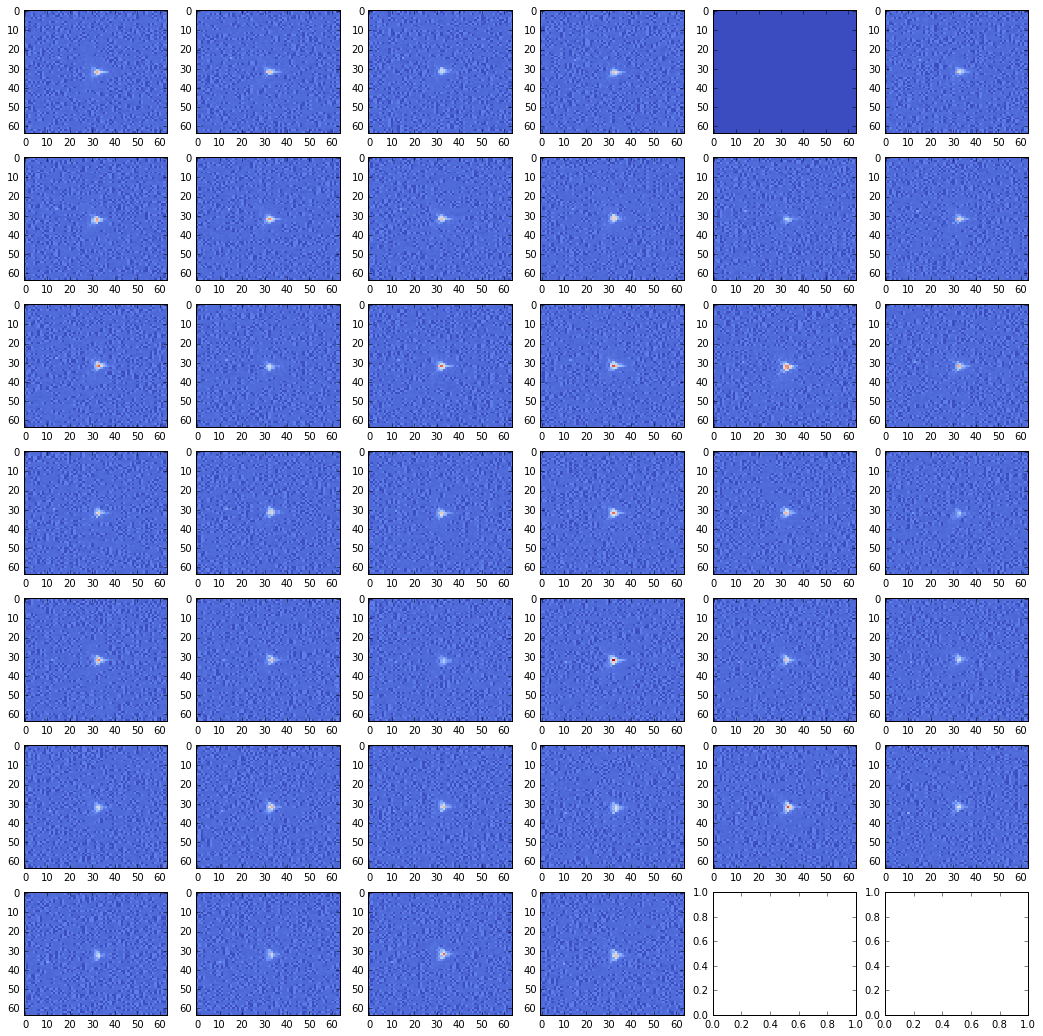

In [67]:
cloud_focus.plot_stamps(stars[180:220])

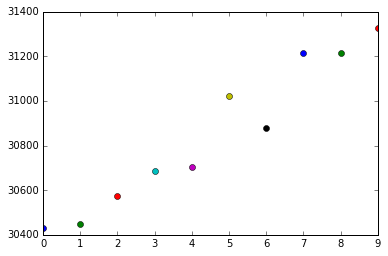

In [390]:
for k,stamp in enumerate(stamps):
    plot(k,stamp.max(),'o')

In [331]:
imset[0].shape

(3232, 4864)

In [332]:
3232-768

2464

In [333]:
4864-1024

3840

In [327]:
x.shape

(2465, 3841)

In [328]:
imset[0].shape

(3232, 4864)

In [334]:
np.unravel_index(x.argmax(),x.shape)

(389, 3285)

In [293]:
3841-2868

973

In [294]:
1024-973

51

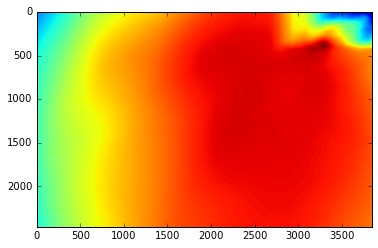

In [335]:
plt.imshow(x)

In [336]:
import pmc_camera

ImportError: No module named pmc_camera

In [178]:
np.abs(ir).min()

1.4925120359987436e-09

In [180]:
np.abs(ir).argmax()

0

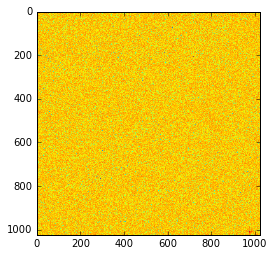

In [179]:
plt.imshow(np.log10(np.abs(ir)))

In [216]:
scale

1.0

In [247]:
offsets = []
for k in range(19):
    (t0,t1),ir = translation(imset[0+k][:1024,-2048:-1024],imset[1+k][:1024,-2048:-1024])
    offsets.append((t0,t1))

In [248]:
offsets = np.array(offsets)

In [222]:
offsets.shape

(9, 2)

In [249]:
offsets

array([[-15, -52],
       [-15, -52],
       [-15, -53],
       [-15, -52],
       [-15, -52],
       [-15, -52],
       [-14, -52],
       [-15, -52],
       [-15, -52],
       [-14, -52],
       [-14, -52],
       [-14, -52],
       [-14, -52],
       [-14, -52],
       [-15, -51],
       [-16, -52],
       [-14, -51],
       [-15, -51],
       [  1,   0]])

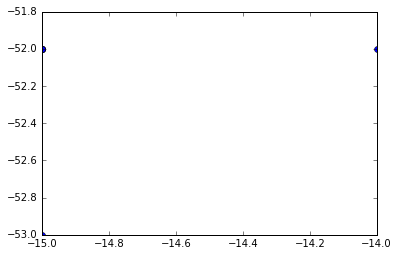

In [227]:
plot(offsets[:,0],offsets[:,1],'o')

In [250]:
stamps = [imset[k][(k*15):(1024+15*k),(-2048+52*k):(-1024+52*k)] for k in range(20)]

In [245]:
np.unravel_index(imset[0].argmax(),imset[0].shape)

(0, 3620)

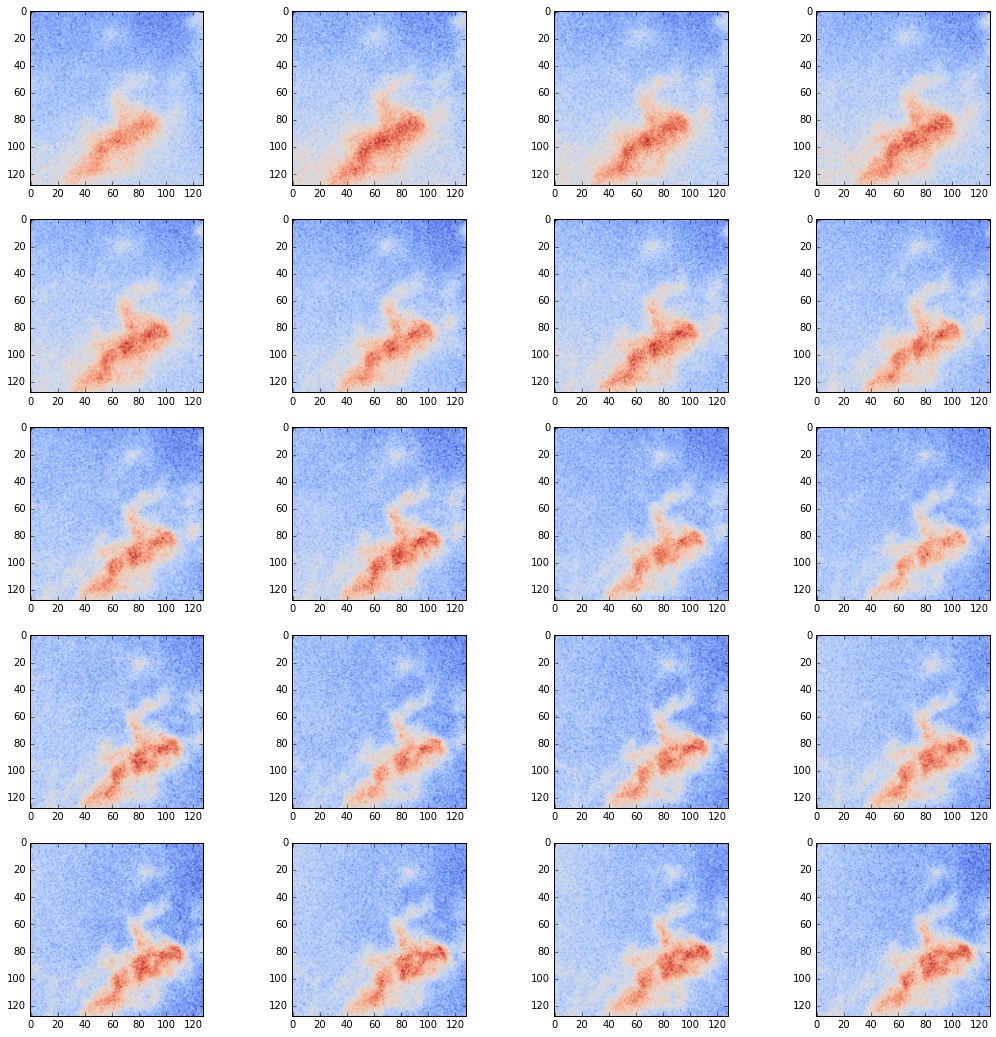

In [284]:
fig,axs = subplots(5,4,figsize=(18,18))
for k,ax in enumerate(axs.flatten()):
    ax.imshow(stamps[k][128:256,128:256],cmap=cm.coolwarm)
    #ax.imshow(cv2.Sobel(stamps[k][128:256,128:256],cv2.CV_32F,1,0,ksize=5),cmap=cm.coolwarm)

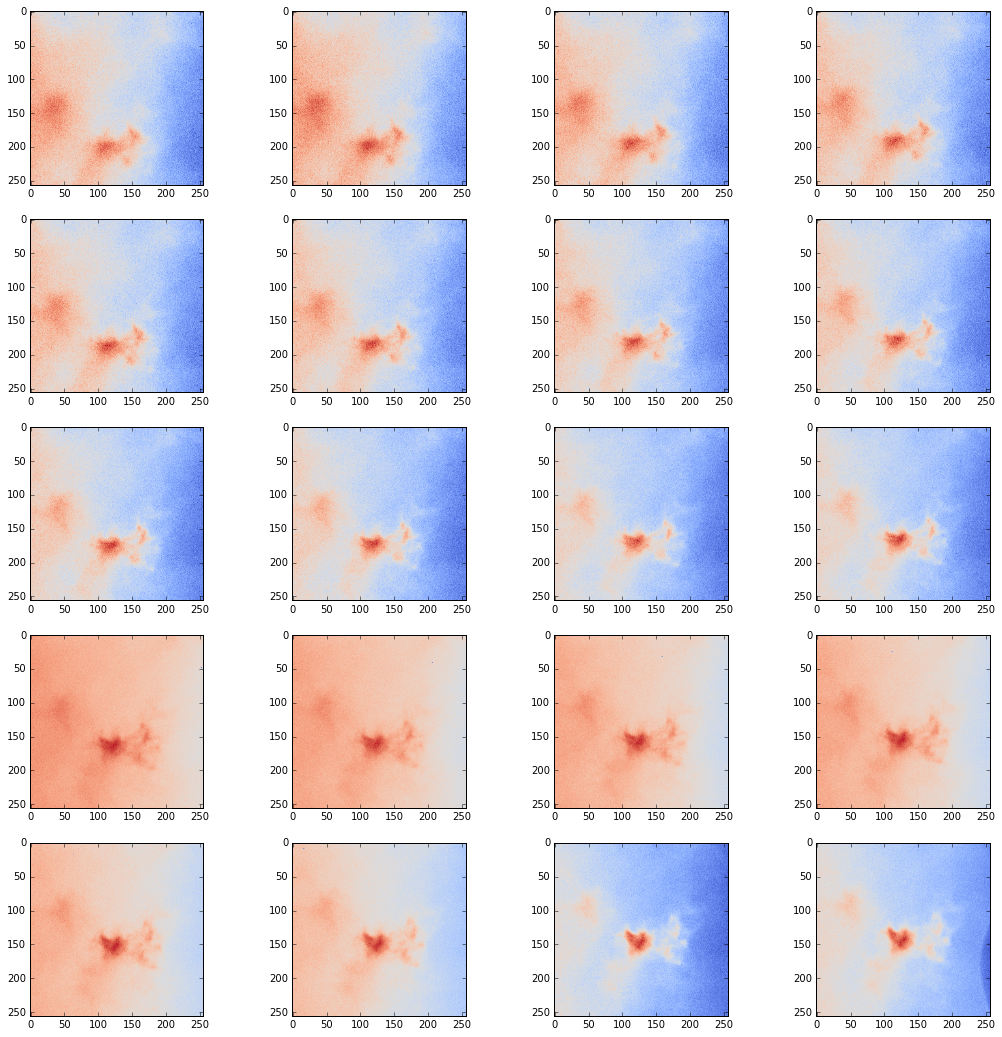

In [280]:
fig,axs = subplots(5,4,figsize=(18,18))
for k,ax in enumerate(axs.flatten()):
    ii = ax.imshow(stamps[k][-256-128-k*7:-128-7*k,-512+128-k*5:-256+128-k*5],cmap=cm.coolwarm)
    #ii.set_clim(2**14,2**16)

In [217]:
angle

0.0

In [218]:
t0,t1

(30, 105)

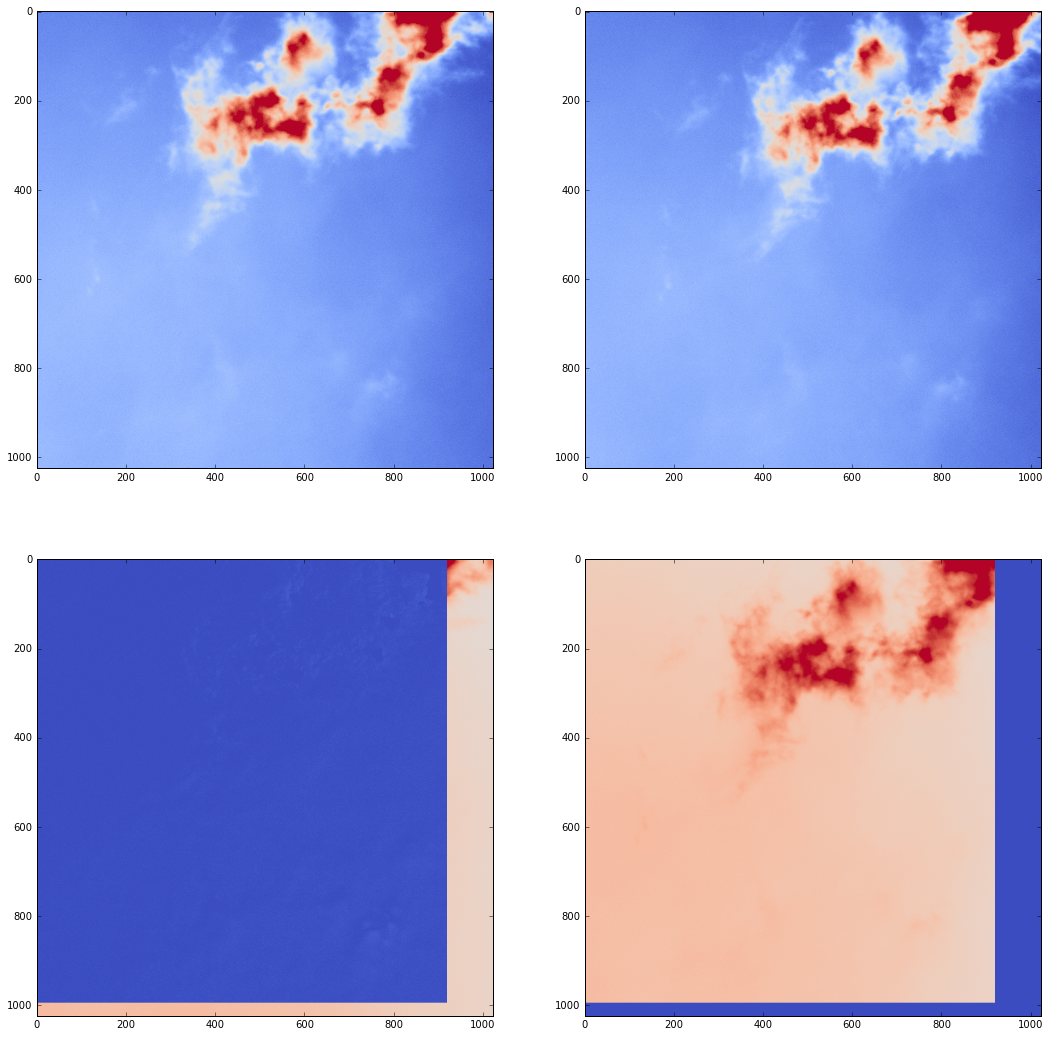

In [219]:
figure(figsize=(18,18))
imshow(imset[0][:1024,-2048:-1024],imset[1][:1024,-2048:-1024],im2)

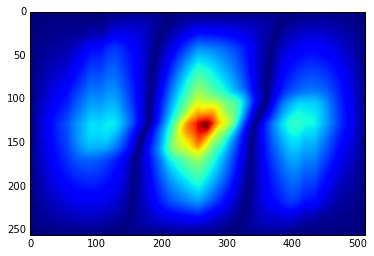

In [135]:
imshow(np.abs(c[::8,::8]),aspect='auto')

In [16]:
im = im.astype('float32')

In [23]:
dv = im[2:,2:]-im[:-2,2:]
dh = im[2:,2:]-im[2:,:-2]
fm = np.mean(np.max((dv,dh),axis=0)**2)

In [24]:
fm

132155.45

In [22]:
fm.shape

(3230, 4862)